In [1]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [2]:
# data parameters
n_monto_carlo = 10 ** 5
n_assets = 7
risky_asset = ['TSLA', 'AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMZN', 'META']

In [21]:
# download the data
prices_df = pd.read_csv("RNN.csv")
prices_df = prices_df[1261:]
for i in risky_asset:
    prices_df.drop(columns=[f'Observed_{i}'], inplace=True)
    prices_df.drop(columns=[f'Train_Prediction_{i}'], inplace=True)
prices_df.set_index('Date', inplace=True)
print(f'read {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df = prices_df.dropna()
prices_df.head()

read 852 rows of data.


,Test_Prediction_AAPL,Test_Prediction_TSLA,Test_Prediction_MSFT,Test_Prediction_NVDA,Test_Prediction_GOOGL,Test_Prediction_AMZN,Test_Prediction_META
Date,,,,,,,
2021-01-06,109.084671,205.132812,199.083359,134.958572,74.722603,152.422348,248.350204
2021-01-07,119.728996,181.073639,189.050293,128.712097,84.660858,172.244690,266.212830
2021-01-08,122.344856,180.001358,205.387680,120.976013,78.605888,150.489563,243.856018
2021-01-11,121.686226,185.449768,209.230057,133.697220,77.991821,149.288239,247.435150
2021-01-12,114.234116,197.090820,206.939407,137.983337,78.651550,140.279770,252.356201


In [22]:
# show the percentage returns

returns_df = prices_df.pct_change()
returns_df.dropna(inplace=True)
returns_df.head()

,Test_Prediction_AAPL,Test_Prediction_TSLA,Test_Prediction_MSFT,Test_Prediction_NVDA,Test_Prediction_GOOGL,Test_Prediction_AMZN,Test_Prediction_META
Date,,,,,,,
2021-01-07,0.097579,-0.117286,-0.050396,-0.046284,0.133002,0.130049,0.071925
2021-01-08,0.021848,-0.005922,0.086418,-0.060104,-0.071520,-0.126304,-0.083981
2021-01-11,-0.005383,0.030269,0.018708,0.105155,-0.007812,-0.007983,0.014677
2021-01-12,-0.061240,0.062772,-0.010948,0.032058,0.008459,-0.060343,0.019888
2021-01-13,0.031378,-0.001084,-0.094171,-0.010504,0.010908,0.008544,-0.005034


In [23]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Test_Prediction_AAPL      8.891275
 Test_Prediction_TSLA     21.220442
 Test_Prediction_MSFT      6.591681
 Test_Prediction_NVDA     14.365784
 Test_Prediction_GOOGL    12.658109
 Test_Prediction_AMZN      4.570925
 Test_Prediction_META      4.720073
 dtype: float64,
                        Test_Prediction_AAPL  Test_Prediction_TSLA  \
 Test_Prediction_AAPL              17.454578              9.069116   
 Test_Prediction_TSLA               9.069116             42.344429   
 Test_Prediction_MSFT              -0.828252              6.859530   
 Test_Prediction_NVDA              -4.625768              3.053155   
 Test_Prediction_GOOGL             -9.622657            -12.579775   
 Test_Prediction_AMZN               5.242708              0.102582   
 Test_Prediction_META               0.127967             -0.152308   
 
                        Test_Prediction_MSFT  Test_Prediction_NVDA  \
 Test_Prediction_AAPL              -0.828252             -4.625768   
 Test_Prediction_TSLA        

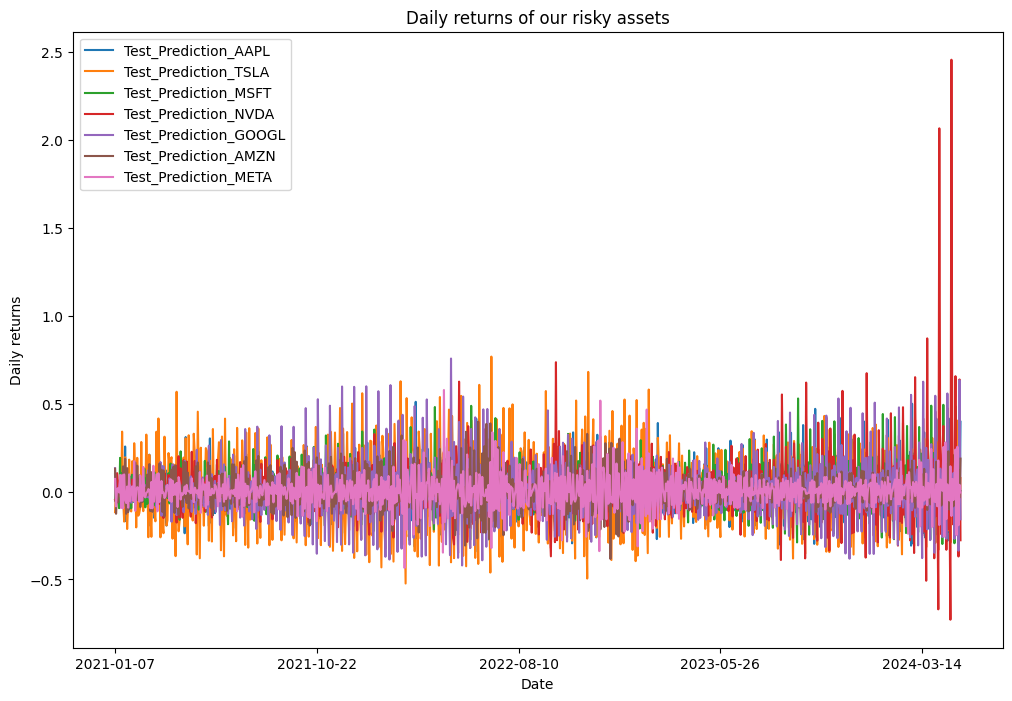

In [24]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [25]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [26]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [27]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [28]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

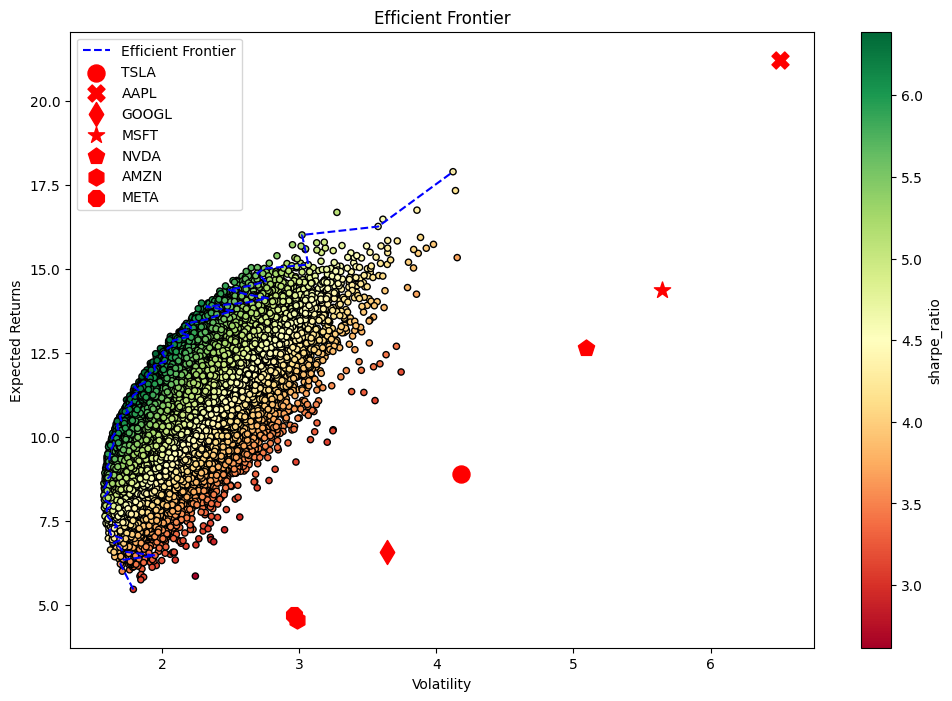

In [29]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

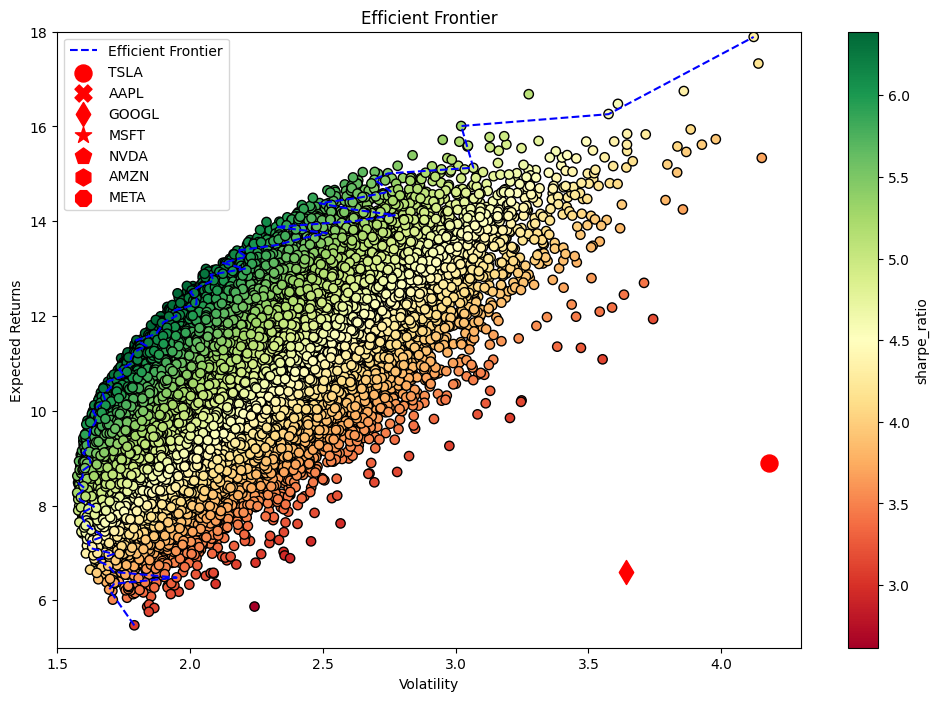

In [33]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax, s = 45)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier(scale up)',\
       xlim = (1.5, 4.3), ylim = (5, 18))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [34]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [35]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 1149.05% volatility: 179.85% sharpe_ratio: 638.90% 
Weights:
TSLA: 16.28% AAPL: 17.75% GOOGL: 1.18% MSFT: 11.95% NVDA: 25.34% AMZN: 16.04% META: 11.46% 

In [36]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 827.07% volatility: 157.59% sharpe_ratio: 524.81% 
Weights:
TSLA: 13.21% AAPL: 4.43% GOOGL: 5.21% MSFT: 10.45% NVDA: 15.13% AMZN: 25.46% META: 26.11% 

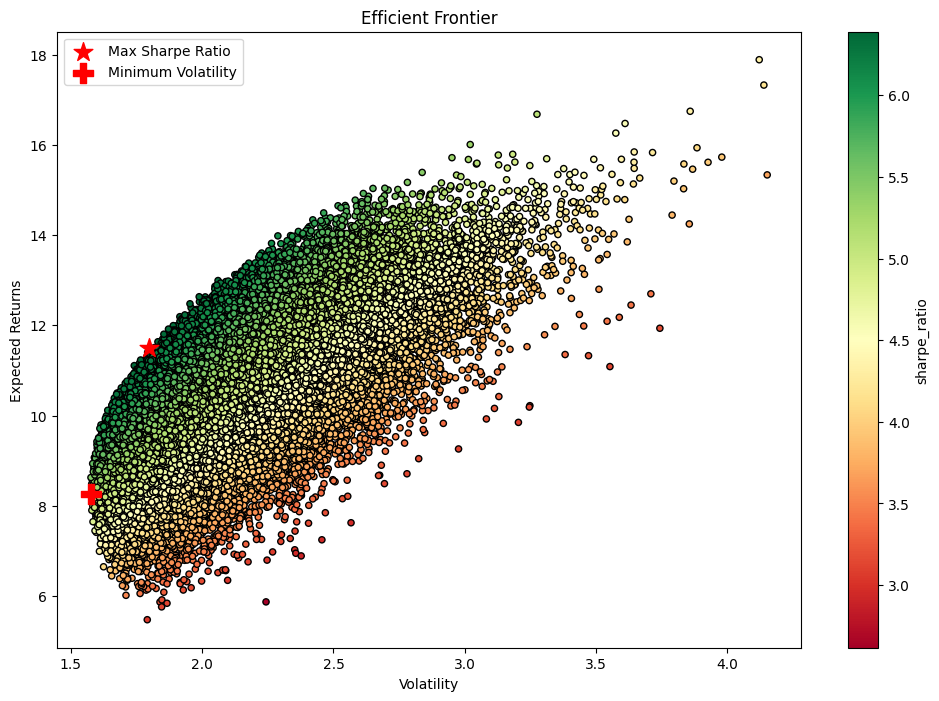

In [37]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()